You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

# Competition Overview
In this competition you will work with a challenging **time-series** dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

### File descriptions
- **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
- **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
- **sample_submission.csv** - a sample submission file in the correct format.
- **items.csv** - supplemental information about the items/products.
- **item_categories.csv**  - supplemental information about the items categories.
- **shops.csv**- supplemental information about the shops.


## Loading Libraries

In [19]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()

from itertools import product

## Load data
Submissions are evaluated by **root mean squared error (RMSE)**. True target values are clipped into [0,20] range.

In [3]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')
test = pd.read_csv('../readonly/final_project_data/test.csv')
submission = pd.read_csv('../readonly/final_project_data/sample_submission.csv')

Let's check data shapes.

In [18]:
print('Size of sales :', sales.shape)
print('Size of test :', test.shape)
print('Size of shops :', shops.shape)
print('Size of items :', items.shape)
print('Size of item_cats :', item_cats.shape)


Size of sales : (2935849, 6)
Size of test : (214200, 3)
Size of shops : (60, 2)
Size of items : (22170, 3)
Size of item_cats : (84, 2)


# Explorary Data Analysis
- **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
- **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

In [7]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [14]:
print('Train Unique shops :', len(sales['shop_id'].unique()))
print('Test Unique shops :', len(test['shop_id'].unique()))
print('Train Unique items:', len(sales['item_id'].unique()))
print('Test Unique items :', len(test['item_id'].unique()))
print('min item prize :', min(sales['item_price']))
print('max item prize :', max(sales['item_price']))

Train Unique shops : 60
Test Unique shops : 42
Train Unique items: 21807
Test Unique items : 5100
min item prize : -1.0
max item prize : 307980.0


## Check for missing data
It seems look pretty good that there is no missing data.

In [17]:
sales.isnull().sum().sort_values(ascending = False)

item_cnt_day      0
item_price        0
item_id           0
shop_id           0
date_block_num    0
date              0
dtype: int64

TypeError: slice indices must be integers or None or have an __index__ method

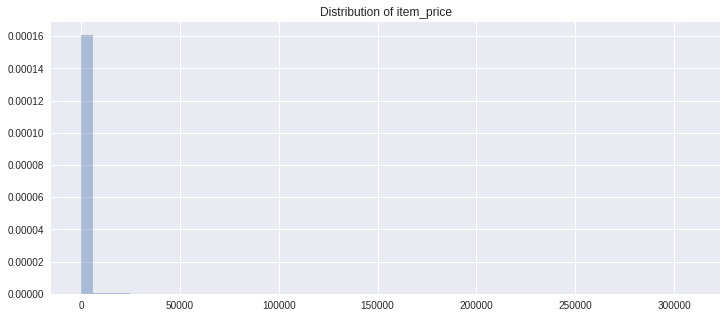

In [22]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_price")
ax = sns.distplot(sales['item_price'])